Find transformations with base model that maximize the difference between prediction and shuffled prediction

In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants, split_participants_into_folds
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from collections import defaultdict
from hmpai.pytorch.mamba import *
import os
from copy import deepcopy
import json
from hmpai.pytorch.utilities import save_tensor
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = Path(os.getenv("DATA_PATH"))
models = []
N_FOLDS = 6
labels = SAT_CLASSES_ACCURACY


#### Visualize results

In [3]:
logs_path = Path("../../logs/transformation_validation_kldiv")
files = list(logs_path.glob('*/*.csv'))
dataframes = []

for file in files:
    data = pd.read_csv(file)
    data['transform'] = file.parts[-2] # Get transform name
    data['fold'] = int(re.search('[0-9]*\.', file.parts[-1])[0][:-1]) # Get fold index
    dataframes.append(data)

data = pd.concat(dataframes)

In [4]:
uq_transforms = data[~data['transform'].str.contains('-')]['transform'].unique()
legend_labels = {''.join([char for char in tf if char.isupper() or char == '-']): tf  for tf in uq_transforms}
legend_labels = [f"{abbr}: {name}" for abbr, name in legend_labels.items()]

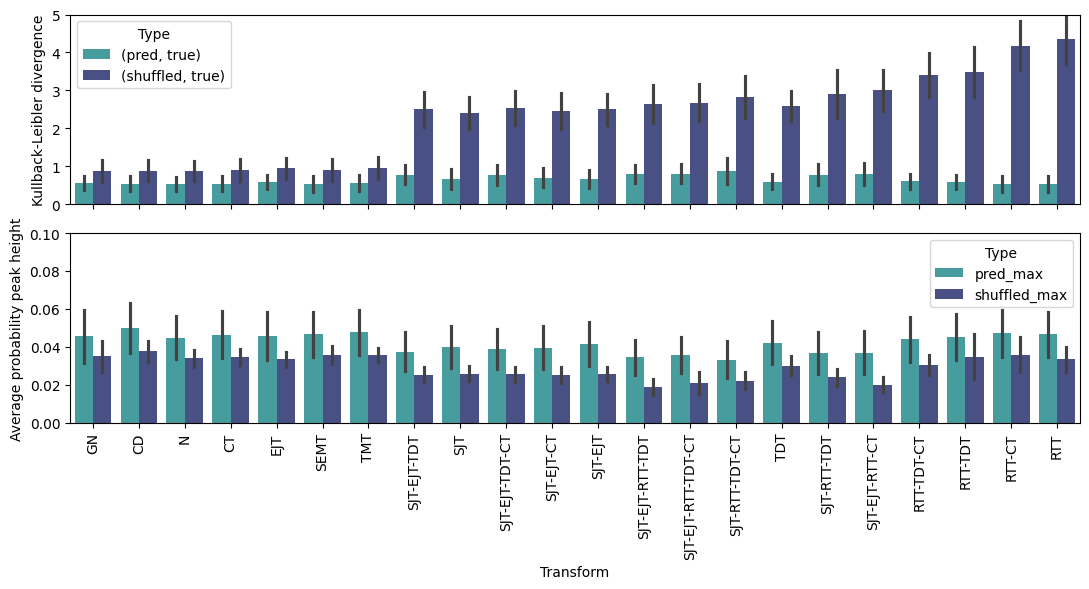

In [25]:
data['(pred, true)'] = data[['0', '1', '2', '3']].mean(axis=1)
data['(shuffled, true)'] = data[['4', '5', '6', '7']].mean(axis=1)
data['pred_max'] = data[['8', '9', '10', '11']].mean(axis=1)
data['shuffled_max'] = data[['12', '13', '14', '15']].mean(axis=1)

data['transform'] = data['transform'].apply(lambda x: ''.join([char for char in x if char.isupper() or char == '-']))
data_melted = pd.melt(data, id_vars=['transform'], 
                      value_vars=['(pred, true)', '(shuffled, true)'],
                      var_name='Type', value_name='Average')

data_melted_max = pd.melt(data, id_vars=['transform'], 
                      value_vars=['pred_max', 'shuffled_max'],
                      var_name='Type', value_name='Average')
mean_values = data.groupby(['transform'])[['(pred, true)', '(shuffled, true)']].mean()
mean_values['difference'] = mean_values['(pred, true)'] - mean_values['(shuffled, true)']
ordered_transforms = mean_values.sort_values('difference', ascending=False).index

legend_text = "\n".join(legend_labels)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(len(ordered_transforms)/2, 6))
# plt.figure(figsize=(18, 6))
# plt.figtext(0.91, 0.5, legend_text, fontsize=12, verticalalignment='center')

# TODO: Plot differences over this graph somehow
ax[0].set_ylabel('Kullback-Leibler divergence')
ax[0].set_ylim((0,5))
sns.barplot(x='transform', y='Average', hue='Type', data=data_melted, palette='mako_r',
              order=ordered_transforms, ax=ax[0], errorbar='sd')

sns.barplot(x='transform', y='Average', hue='Type', data=data_melted_max, palette='mako_r',
               order=ordered_transforms, ax=ax[1], errorbar='sd')
ax[1].set_ylim(0, 0.1)
ax[1].set_ylabel('Average probability peak height')
ax[1].set_xlabel('Transform')
plt.xticks(rotation=90)
# plt.ylim(-0.001, 0.001)
plt.tight_layout()
plt.savefig('../../img/transforms.svg', transparent=True)
plt.show()

In [9]:
legend_text

'TDT: TimeDropoutTransform\nSJT: StartJitterTransform\nN: None\nSEMT: StartEndMaskTransform\nEJT: EndJitterTransform\nRTT: ReverseTimeTransform\nCD: ChannelsDropout\nCT: ConcatenateTransform\nGN: GaussianNoise\nTMT: TimeMaskTransform'

#### Run experiment

Define transform configurations, separately for train and testval, probably dont want most transforms in case of testval but should still be configurable

Can probably create dataset per fold, then set transform by doing `train_data.transform=transform`

In [2]:
# First test if transforms by themselves make a difference, assume additive behaviour
transforms = [
    (None, None),
    (Compose([StartJitterTransform(62, 1.0)]), None),
    (Compose([EndJitterTransform(63, 1.0)]), None),
    (Compose([ReverseTimeTransform()]), None),
    (Compose([GaussianNoise()]), None),
    (Compose([TimeMaskTransform()]), None),
    (Compose([TimeDropoutTransform()]), None),
    (Compose([ChannelsDropout()]), None),
    (Compose([ConcatenateTransform(0.5)]), None),
    (Compose([StartEndMaskTransform(0.5)]), None),
    (Compose([ReverseTimeTransform(), ConcatenateTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0)]), None),
    (Compose([ReverseTimeTransform(), TimeDropoutTransform()]), None),
    (Compose([ReverseTimeTransform(), TimeDropoutTransform(), ConcatenateTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), ReverseTimeTransform(), TimeDropoutTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), ReverseTimeTransform(), TimeDropoutTransform(), ConcatenateTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0), ReverseTimeTransform(), TimeDropoutTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0), ReverseTimeTransform(), ConcatenateTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0), ReverseTimeTransform(), TimeDropoutTransform(), ConcatenateTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0), ConcatenateTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0), TimeDropoutTransform()]), None),
    (Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0), TimeDropoutTransform(), ConcatenateTransform()]), None),

]

In [3]:
def test_transform(transforms: tuple[Compose | None, Compose | None]) -> None:
    data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]
    # data_paths = [data_path_1] # TODO: Both paths

    logs_path = Path("../../logs/transformation_validation_mse")

    set_global_seed(42)
    folds = split_participants_into_folds(data_paths, N_FOLDS)

    torch.cuda.empty_cache()

    train_transform = transforms[0]
    testval_transform = transforms[1]

    transform_name = '-'.join([tf.__class__.__name__  if tf is not None else 'None' for tf in train_transform.transforms]) if train_transform is not None else 'None'

    for i_fold in range(len(folds)):
        train_folds = deepcopy(folds)
        test_fold = train_folds.pop(i_fold)
        train_fold = np.concatenate(train_folds, axis=0)
        print(f"Fold {i_fold + 1}: test fold: {test_fold}")
        
        whole_epoch = True
        # Maybe 'accuracy'? probably not necessary
        subset_cond = 'accuracy'
        add_negative = True
        norm_fn = norm_mad_zscore

        run_name = f"transform-{transform_name}_fold-{i_fold}"

        train_data = MultiXArrayProbaDataset(
            data_paths,
            participants_to_keep=train_fold,
            normalization_fn=norm_fn,
            whole_epoch=whole_epoch,
            labels=labels,
            subset_cond=subset_cond,
            add_negative=add_negative,
            transform=train_transform,
        )

        norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
        class_weights = train_data.statistics["class_weights"]
        testval_data = MultiXArrayProbaDataset(
            data_paths,
            participants_to_keep=test_fold,
            normalization_fn=norm_fn,
            norm_vars=norm_vars,
            whole_epoch=whole_epoch,
            labels=labels,
            subset_cond=subset_cond,
            add_negative=add_negative,
            transform=testval_transform
        )

        model = base_mamba()
        test_result = train_and_test(
            model,
            train_data,
            testval_data,
            testval_data,
            logs_path=logs_path / transform_name,
            workers=8,
            batch_size=64,
            labels=labels,
            lr=0.0005, # 0.0001
            use_class_weights=False,
            class_weights=class_weights,
            whole_epoch=whole_epoch,
            epochs=20,
            additional_name=run_name,
            do_test_shuffled=True
        )
        print(f"Fold {i_fold + 1}, transform: {run_name}: metric_pred shape: {test_result[0]['metric_pred'].shape}")
        save_tensor(torch.cat((test_result[0]['metric_pred'], test_result[0]['metric_shuffled'], test_result[0]['peaks_pred'], test_result[0]['peaks_shuffled']), dim=1), logs_path / transform_name / f"{run_name}.csv")


In [4]:
test_transform(transforms[0])

Fold 1: test fold: ['S1' 'S10' 'S18']


  0%|          | 0/255 [00:00<?, ? batch/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

  0%|          | 0/255 [00:00<?, ? batch/s]

Fold 1, transform: transform-None_fold-0: metric_pred shape: torch.Size([3420, 4])
Fold 2: test fold: ['S15' 'S12' 'S5']


  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

  0%|          | 0/253 [00:00<?, ? batch/s]

Fold 2, transform: transform-None_fold-1: metric_pred shape: torch.Size([3553, 4])
Fold 3: test fold: ['S8' 'S7' 'S3']


  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

  0%|          | 0/256 [00:00<?, ? batch/s]

KeyboardInterrupt: 

In [ ]:
test_transform(transforms[1])

In [ ]:
test_transform(transforms[2])

In [ ]:
test_transform(transforms[3])

In [ ]:
test_transform(transforms[4])

In [20]:
test_transform(transforms[5])

Fold 1: test fold: ['S1' 'S10']


  0%|          | 0/137 [00:00<?, ? batch/s]

  0%|          | 0/137 [00:00<?, ? batch/s]

Fold 1, transform: transform-TimeMaskTransform_fold-0: metric_pred shape: torch.Size([2264, 4])
Fold 2: test fold: ['S18' 'S15']


  0%|          | 0/136 [00:00<?, ? batch/s]

  0%|          | 0/136 [00:00<?, ? batch/s]

KeyboardInterrupt: 

In [16]:
test_transform(transforms[6])

Fold 1: test fold: ['S1' 'S10']


  0%|          | 0/274 [00:00<?, ? batch/s]

FileNotFoundError: [Errno 2] No such file or directory: '../../logs/transformation_validation/TimeDropoutTransform/20241028-091017_transform-TimeDropoutTransform_fold-0/checkpoint.pt'

In [ ]:
test_transform(transforms[7])

In [ ]:
test_transform(transforms[8])

In [ ]:
test_transform(transforms[9])

In [ ]:
test_transform(transforms[10])

In [ ]:
test_transform(transforms[11])

In [ ]:
test_transform(transforms[12])

In [ ]:
test_transform(transforms[13])

In [ ]:
test_transform(transforms[14])

In [ ]:
test_transform(transforms[15])

In [ ]:
test_transform(transforms[16])

In [ ]:
test_transform(transforms[17])

In [ ]:
test_transform(transforms[18])

In [ ]:
test_transform(transforms[19])

In [ ]:
test_transform(transforms[20])

In [ ]:
test_transform(transforms[21])

### Deprecated

In [ ]:


data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
data_paths = [data_path_1, data_path_2]
# data_paths = [data_path_1] # TODO: Both paths

logs_path = Path("../../logs/transformation_validation")

set_global_seed(42)
folds = split_participants_into_folds(data_paths, N_FOLDS)

results = defaultdict(list)
torch.cuda.empty_cache()

for i_fold in range(len(folds)):
    train_folds = deepcopy(folds)
    test_fold = train_folds.pop(i_fold)
    train_fold = np.concatenate(train_folds, axis=0)
    print(f"Fold {i_fold + 1}: test fold: {test_fold}")

    labels = SAT_CLASSES_ACCURACY
    whole_epoch = True
    # Maybe 'accuracy'? probably not necessary
    subset_cond = 'accuracy'
    add_negative = True
    norm_fn = norm_mad_zscore

    train_data = MultiXArrayProbaDataset(
        data_paths,
        participants_to_keep=train_fold,
        normalization_fn=norm_fn,
        whole_epoch=whole_epoch,
        labels=labels,
        subset_cond=subset_cond,
        add_negative=add_negative,
    )
    norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
    class_weights = train_data.statistics["class_weights"]
    testval_data = MultiXArrayProbaDataset(
        data_paths,
        participants_to_keep=test_fold,
        normalization_fn=norm_fn,
        norm_vars=norm_vars,
        whole_epoch=whole_epoch,
        labels=labels,
        subset_cond=subset_cond,
        add_negative=add_negative,
    )

    for i_t, (t_train, t_test) in enumerate(transforms):
        # Set transforms
        train_data.transform = t_train
        testval_data.transform = t_test

        model = base_mamba()
        additional_name = 'None' if t_train is None else f"transform-{t_train.transforms[0].__class__.__name__}_fold-{i_fold}"
        test_result = train_and_test(
            model,
            train_data,
            testval_data,
            testval_data,
            logs_path=logs_path,
            workers=8,
            batch_size=64,
            labels=labels,
            lr=0.0005, # 0.0001
            use_class_weights=False,
            class_weights=class_weights,
            whole_epoch=whole_epoch,
            epochs=20,
            additional_name=additional_name,
            do_test_shuffled=True
        )
        print(f"Fold {i_fold + 1}, transform: {str(t_train)}: EMD: {test_result[0]['EMD']}, EMD_raw: {test_result[0]['EMD_raw'].shape}")
        for i, result in enumerate(test_result):
            results[i_t].append(result)

for i_t, (t_train, t_test) in enumerate(transforms):
    if isinstance(type(results[i_t][0]), dict):
        with open(logs_path / f"results_{str(t_train)}.json", "w") as f:
            json.dump(results[i_t], f, indent=4)
    else:
        for i_fold, fold in enumerate(results[i_t]):
            tensors = fold["EMD_raw"]
            name = 'None' if t_train is None else t_train.transforms[0].__class__.__name__
            save_tensor(tensors, logs_path / f"results_{name}_fold_{i_fold}.csv")
